<a href="https://colab.research.google.com/github/Mehwish-data/Ecommerce-Sales-Analysis/blob/main/Model_2_Commerce_Sales_Analysis_Using_SQL%2C_Pandas%2C_and_GitHub_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Essential libraries

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import sqlite3
import csv

# Creating an sqlite database file


In [ ]:
conn=sqlite3.connect("ecommerce.db")
cursor=conn.cursor()

# 1: Creating Essential tables

In [ ]:
cursor.execute("""
CREATE TABLE IF NOT EXISTS Orders (
    TransactionID INTEGER,
    OrderDate TEXT,
    CustomerID INTEGER,
    ProductID INTEGER,
    Quantity INTEGER,
    TotalAmount REAL
)
""")

cursor.execute("""
CREATE TABLE IF NOT EXISTS Products (
    ProductID INTEGER,
    ProductName TEXT,
    Category TEXT,
    Price REAL
)
""")

cursor.execute("""
CREATE TABLE IF NOT EXISTS Customers (
    CustomerID INTEGER,
    Name TEXT,
    Region TEXT,
    Segment TEXT
)
""")

cursor.execute("""
CREATE TABLE IF NOT EXISTS Sales (
    OrderID INTEGER,
    Revenue REAL,
    Discounts REAL,
    Taxes REAL
)
""")

conn.commit()


# **2: [Download Dataset ](https://)**

In [ ]:
import pandas as pd

Orders = pd.read_csv("https://raw.githubusercontent.com/Mehwish-data/Ecommerce-Sales-Analysis/main/Dataset/Orders_Large.csv")
Products = pd.read_csv("https://raw.githubusercontent.com/Mehwish-data/Ecommerce-Sales-Analysis/main/Dataset/Products_Large.csv")
Customers = pd.read_csv("https://raw.githubusercontent.com/Mehwish-data/Ecommerce-Sales-Analysis/main/Dataset/Customers_Large.csv")
Sales = pd.read_csv("https://raw.githubusercontent.com/Mehwish-data/Ecommerce-Sales-Analysis/main/Dataset/Sales_Large.csv")


# 3: Convert csv to sql tables

In [ ]:
Orders.to_sql("Orders",conn, if_exists="replace",index=False)
Products.to_sql("Products",conn, if_exists="replace",index=False)
Customers.to_sql("Customers",conn, if_exists="replace",index=False)
Sales.to_sql("Sales",conn, if_exists="replace",index=False)
print("Data sucessfuly loaded into sqlite database")

Data sucessfuly loaded into sqlite database


## Varify dataset

In [ ]:
Orders=pd.read_sql("select * from Orders",conn)
print(Orders.head())

   TransactionID   OrderDate  CustomerID  ProductID  Quantity  TotalAmount
0           1000  2023-02-11           6        212         4          426
1           1001  2024-06-09          22        226         8          184
2           1002  2022-12-11          31        231         5          880
3           1003  2022-12-18          23        227        10          928
4           1004  2024-04-11          42        215         7          517


In [ ]:
Products=pd.read_sql("select * from Products",conn)
print(Products.head())

   ProductID     ProductName         Category  Price
0        200          Report            Books     89
1        201           Shake      Electronics    226
2        202           Skill            Books    494
3        203            Into  Home Appliances    160
4        204  Responsibility            Books    479


In [ ]:
Customers=pd.read_sql("select * from Customers",conn)
print(Customers.head())

   CustomerID               Name   Region    Segment
0           1  Christina Harrell     East  Corporate
1           2      David Charles     East  Corporate
2           3      Cheryl Harris     East  Corporate
3           4       Cameron King  Central  Corporate
4           5          Tanya Kim     West  Corporate


In [ ]:
Sales=pd.read_sql("select * from Sales",conn)
print(Sales.head())

   OrderID  Revenue  Discounts  Taxes
0     1000     1755         30     65
1     1001     1727         76    101
2     1002     1834         25     23
3     1003      896         94    123
4     1004     1868         51     63


# Creating one table by joining all tables

In [ ]:
# Create 'customorder' table by joining Customers and Orders
cursor.execute("""
    CREATE TABLE IF NOT EXISTS customorder AS
    SELECT
        c.CustomerID,
        c.Name,
        c.Region,
        c.Segment,
        o.TransactionID,
        o.OrderDate,
        o.ProductID,
        o.Quantity,
        o.TotalAmount
    FROM Customers c
    JOIN Orders o ON c.CustomerID = o.CustomerID;
""")

# Create 'procustomorder' table by joining customorder with Products
cursor.execute("""
    CREATE TABLE IF NOT EXISTS procustomorder AS
    SELECT
        p.ProductID,
        p.ProductName,
        p.Category,
        p.Price,
        co.CustomerID,
        co.Name,
        co.Region,
        co.Segment,
        co.TransactionID,
        co.OrderDate,
        co.Quantity,
        co.TotalAmount
    FROM Products p
    JOIN customorder co ON p.ProductID = co.ProductID;
""")

# Create 'sales_data' table by joining procustomorder with Sales
cursor.execute("""
    CREATE TABLE IF NOT EXISTS sales_data AS
    SELECT
        s.OrderID,
        s.Revenue,
        s.Discounts,
        s.Taxes,
        co.ProductID,
        co.ProductName,
        co.Category,
        co.Price,
        co.CustomerID,
        co.Name,
        co.Region,
        co.Segment,
        co.OrderDate,
        co.Quantity,
        co.TotalAmount
    FROM Sales s
    JOIN procustomorder co ON s.OrderID = co.TransactionID;
""")

# Commit all changes to the database
conn.commit()


## **Veryfy table created or not **

In [ ]:
# Reconnect to the SQLite database
conn = sqlite3.connect("ecommerce.db")
sales_data = pd.read_sql("SELECT * FROM sales_data", conn)
print(sales_data.head())

   OrderID  Revenue  Discounts  Taxes  ProductID ProductName         Category  \
0     1000     1755         30     65        212        Mind      Accessories   
1     1001     1727         76    101        226      Suffer      Accessories   
2     1002     1834         25     23        231        Role  Home Appliances   
3     1003      896         94    123        227       North  Home Appliances   
4     1004     1868         51     63        215        Both      Accessories   

   Price  CustomerID          Name   Region    Segment   OrderDate  Quantity  \
0     67           6  Lauren Walls     West  Wholesale  2023-02-11         4   
1    179          22     Lori Cole  Central  Wholesale  2024-06-09         8   
2     82          31   Sherri Knox    South  Wholesale  2022-12-11         5   
3    221          23    Randy Duke    North     Retail  2022-12-18        10   
4    334          42   Zachary Ray  Central  Corporate  2024-04-11         7   

   TotalAmount  
0          426 

# 2. SQL Tasks
# 1:Total sales revenue by month.

In [ ]:
# SQL query to get total monthly revenue
query = """
SELECT
    strftime('%Y-%m', OrderDate) AS month,
    SUM(Revenue) AS TotalRevenue
FROM sales_data
GROUP BY month
ORDER BY month ASC;
"""

# Execute the query
cursor.execute(query)
sales_revenue_by_month = cursor.fetchall()

# Write the results to a CSV file
with open('revenue_by_month.csv', 'w', newline='') as csvfile:
    csv_writer = csv.writer(csvfile)
    # Write header
    csv_writer.writerow(['Month', 'TotalRevenue'])
    # Write data rows
    csv_writer.writerows(sales_revenue_by_month)

# Read the CSV into a DataFrame
data1 = pd.read_csv('revenue_by_month.csv')
print(data1)


      Month  TotalRevenue
0   2022-11          9336
1   2022-12         26988
2   2023-01         20160
3   2023-02         17371
4   2023-03         19860
5   2023-04         21539
6   2023-05         24469
7   2023-06         19051
8   2023-07         27406
9   2023-08         23560
10  2023-09         23331
11  2023-10         27643
12  2023-11         19087
13  2023-12         19243
14  2024-01         26647
15  2024-02         14664
16  2024-03         20148
17  2024-04         23562
18  2024-05         30720
19  2024-06         20219
20  2024-07         30688
21  2024-08         23530
22  2024-09         21056
23  2024-10         22526
24  2024-11         11845


# 2:Top 5 best-selling products.

In [ ]:
# SQL query to get top 5 best-selling products by revenue
query = """
SELECT
    ProductName,
    SUM(Revenue) AS TopBestSellingProduct
FROM sales_data
GROUP BY ProductName
ORDER BY TopBestSellingProduct DESC
LIMIT 5;
"""

# Execute the query
cursor.execute(query)
top_best_selling_product = cursor.fetchall()

# Write the results to a CSV file
with open('best_selling_product.csv', 'w', newline='') as csvfile:
    csv_writer = csv.writer(csvfile)
    # Write header
    csv_writer.writerow(['ProductName', 'TopBestSellingProduct'])
    # Write data rows
    csv_writer.writerows(top_best_selling_product)

# Read the CSV into a DataFrame
data2 = pd.read_csv('best_selling_product.csv')
print(data2)


  ProductName  TopBestSellingProduct
0      Notice                  28515
1        Both                  19651
2        Hope                  17570
3        Role                  16135
4      Answer                  15646


# 3:Revenue contribution by customer segments.

In [ ]:
# SQL query to get revenue by segment
query = """
SELECT
    Segment,
    SUM(Revenue) AS RevenueContribution
FROM sales_data
GROUP BY Segment
ORDER BY RevenueContribution DESC;
"""

# Execute the query
cursor.execute(query)
revenue_contribution_by_segment = cursor.fetchall()

# Write the results to a CSV file
with open('revenue_by_segment.csv', 'w', newline='') as csvfile:
    csv_writer = csv.writer(csvfile)
    # Write header
    csv_writer.writerow(['Segment', 'RevenueContribution'])
    # Write data rows
    csv_writer.writerows(revenue_contribution_by_segment)

# Read the CSV into a DataFrame
data3 = pd.read_csv('revenue_by_segment.csv')
print(data3)


     Segment  RevenueContribution
0  Corporate               249656
1  Wholesale               158455
2     Retail               136538


# 4. Identify the top regions for sales

In [ ]:
# SQL query to calculate revenue contribution by region
query = """SELECT Region, SUM(Revenue) AS TotalRevenue
FROM sales_data
GROUP BY Region
ORDER BY TotalRevenue DESC;"""

# Execute the query
cursor.execute(query)
revenue_contribution_by_region = cursor.fetchall()

# Write the result to a CSV file
with open('revenue_by_region.csv', 'w', newline='') as csvfile:
    csv_writer = csv.writer(csvfile)
    # Write header
    csv_writer.writerow(['Region', 'TotalRevenue'])
    # Write data rows
    csv_writer.writerows(revenue_contribution_by_region)

# Load the CSV into a DataFrame and display it
data4 = pd.read_csv('revenue_by_region.csv')
print(data4)


    Region  TotalRevenue
0     West        155950
1  Central        127614
2     East        117258
3    North         89733
4    South         54094


# 5. EDA and Data Visualization

# 3. Pandas Tasks
# Objective: Clean data, perform EDA, and create new columns.
Export the SQL query results into CSV files.
Steps:
# Clean Data:
Handle missing values.

Remove duplicate rows.
## EDA:
Analyze sales trends,

customer behaviors, and product performance.
Feature Engineering:
Create new columns like revenue per product or customer lifetime value.


In [ ]:
# Connect to the SQLite database
conn = sqlite3.connect("ecommerce.db")

# Load the sales_data table into a DataFrame
sales_data = pd.read_sql_query("SELECT * FROM sales_data", conn)

# Specify the output CSV file name
csv_file_name = "sales_data.csv"

# Export the DataFrame to a CSV file
sales_data.to_csv(csv_file_name, index=False)

print(f" Sales data successfully exported to '{csv_file_name}'")


 Sales data successfully exported to 'sales_data.csv'


# displaying DataSet

In [ ]:
df=pd.read_csv("sales_data.csv")
df.head(5)

,OrderID,Revenue,Discounts,Taxes,ProductID,ProductName,Category,Price,CustomerID,Name,Region,Segment,OrderDate,Quantity,TotalAmount
0,1000,1755,30,65,212,Mind,Accessories,67,6,Lauren Walls,West,Wholesale,2023-02-11,4,426
1,1001,1727,76,101,226,Suffer,Accessories,179,22,Lori Cole,Central,Wholesale,2024-06-09,8,184
2,1002,1834,25,23,231,Role,Home Appliances,82,31,Sherri Knox,South,Wholesale,2022-12-11,5,880
3,1003,896,94,123,227,North,Home Appliances,221,23,Randy Duke,North,Retail,2022-12-18,10,928
4,1004,1868,51,63,215,Both,Accessories,334,42,Zachary Ray,Central,Corporate,2024-04-11,7,517


In [ ]:
df.shape

(484, 15)

# Handle missing values.

In [ ]:
df.isnull().sum()

,0
OrderID,0
Revenue,0
Discounts,0
Taxes,0
ProductID,0
ProductName,0
Category,0
Price,0
CustomerID,0
Name,0


# Handling Duplicates

In [ ]:
df.duplicated()

,0
0,False
1,False
2,False
3,False
4,False
...,...
479,False
480,False
481,False
482,False


# Exploring data

In [ ]:
unique_categories=df["Category"].unique()
print(unique_categories)

['Accessories' 'Home Appliances' 'Electronics' 'Books']


In [ ]:
unique_categories=df["ProductName"].unique()
print(unique_categories)

['Mind' 'Suffer' 'Role' 'North' 'Both' 'Dog' 'Care' 'Happen' 'Maybe'
 'Heavy' 'Explain' 'Card' 'Nor' 'Level' 'Pull' 'System' 'Your' 'Present'
 'Just' 'Story' 'Catch' 'Answer' 'Shake' 'Into' 'Protect' 'Notice' 'Size'
 'Despite' 'Gun' 'Dream' 'Friend' 'Price' 'Hope' 'Available' 'Like' 'We'
 'Guess' 'Process' 'Argue' 'Skill' 'Performance' 'Enter' 'Truth'
 'Responsibility' 'Behavior' 'Guy' 'Voice' 'Dinner']


# 4. Basic Data Visualization

In [ ]:
print(data1.columns)

Index(['Month', 'TotalRevenue'], dtype='object')


# 1. Per  month Sales

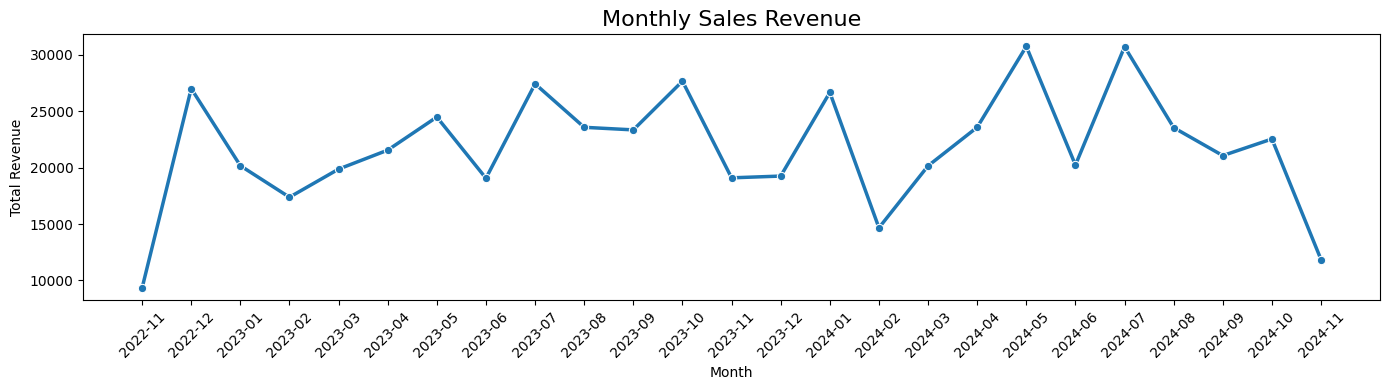

In [ ]:
plt.figure(figsize=(14, 4))
sns.lineplot(data=data1, x="Month", y="TotalRevenue", marker="o", linewidth=2.5)

plt.title("Monthly Sales Revenue", fontsize=16)
plt.xlabel("Month")
plt.ylabel("Total Revenue")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



# 2. Top Selling Products

In [ ]:
print(data2.columns)

Index(['ProductName', 'TopBestSellingProduct'], dtype='object')


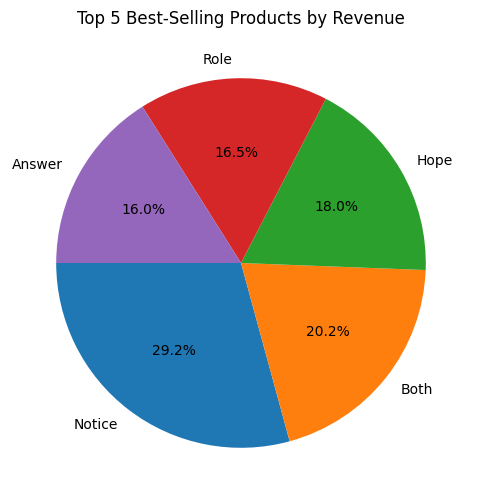

In [ ]:
plt.figure(figsize=(6,6))
plt.pie(data2["TopBestSellingProduct"], labels=data2["ProductName"], autopct="%1.1f%%", startangle=180)
plt.title("Top 5 Best-Selling Products by Revenue")
plt.show()

# 3. Revenue by Customer segment

In [ ]:
print(data3.columns)


Index(['Segment', 'RevenueContribution'], dtype='object')


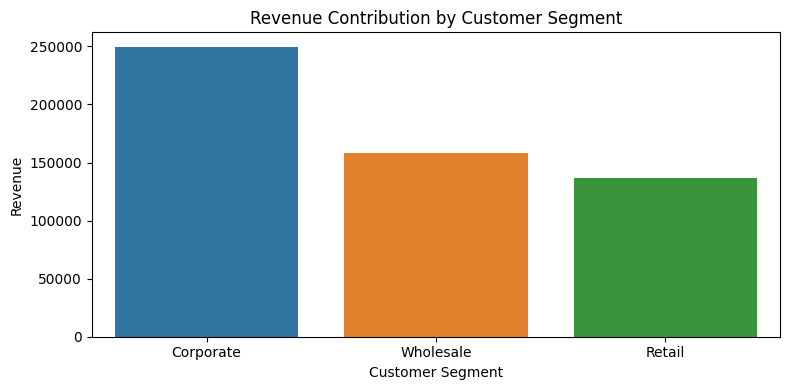

In [ ]:
plt.figure(figsize=(8, 4))
sns.barplot(x="Segment", y="RevenueContribution", data=data3, hue="Segment")
plt.title("Revenue Contribution by Customer Segment")
plt.ylabel("Revenue")
plt.xlabel("Customer Segment")
plt.tight_layout()
plt.show()

# 4. Revenue by Region

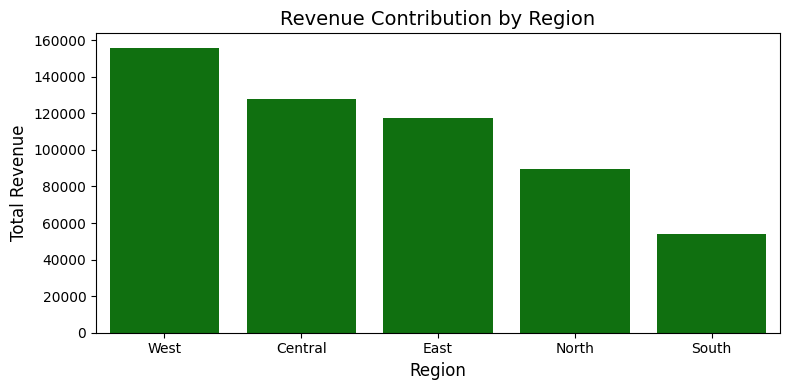

In [ ]:
# Bar plot showing revenue contribution by region
plt.figure(figsize=(8, 4))
sns.barplot(x="Region", y="TotalRevenue", data=data4, color="green")

# Add plot title and axis labels
plt.title("Revenue Contribution by Region", fontsize=14)
plt.xlabel("Region", fontsize=12)
plt.ylabel("Total Revenue", fontsize=12)

# Improve layout
plt.tight_layout()
plt.show()


# 5. HIghest Quantity ordered on which data by which customer

In [ ]:
df.loc[df["Quantity"].idxmax(),["OrderDate","Name","Quantity"]]

,3
OrderDate,2022-12-18
Name,Randy Duke
Quantity,10


# 6. Highest Tax by Category

<ipython-input-34-45c7299b720b>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Category", y="Taxes", data=highest_tax_by_category, palette="viridis")


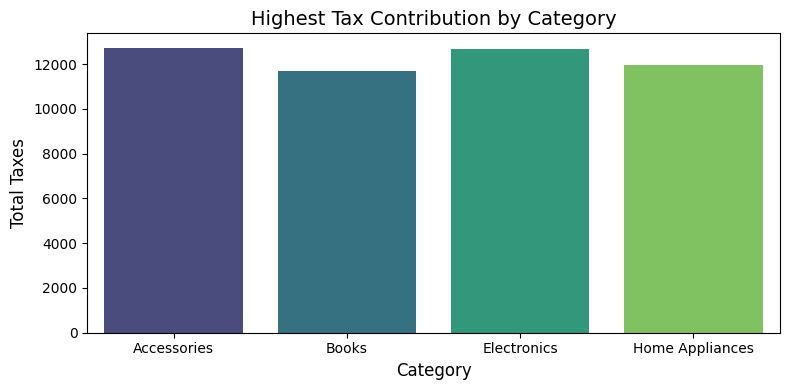

In [ ]:
# Calculate total taxes by category
highest_tax_by_category = df.groupby("Category")["Taxes"].sum().reset_index()

# Create a bar plot for highest tax contribution by category
plt.figure(figsize=(8, 4))
sns.barplot(x="Category", y="Taxes", data=highest_tax_by_category, palette="viridis")

# Add title and axis labels
plt.title("Highest Tax Contribution by Category", fontsize=14)
plt.xlabel("Category", fontsize=12)
plt.ylabel("Total Taxes", fontsize=12)

# Improve layout
plt.tight_layout()
plt.show()


# 7. Highest Taxes paid by customer Segement

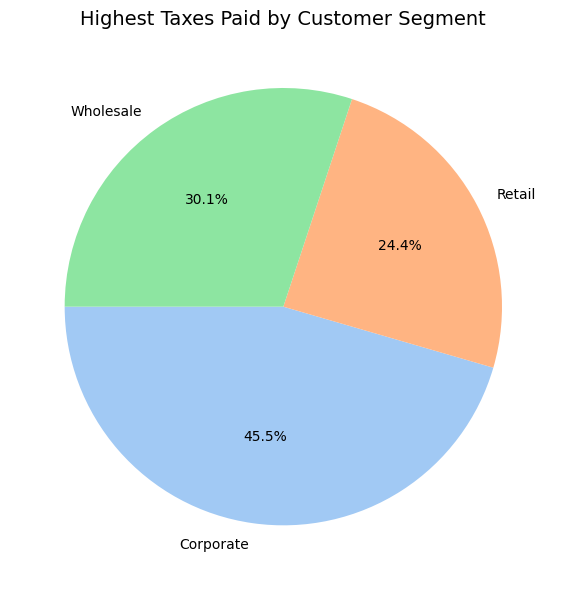

In [ ]:
# Calculate total taxes paid by each segment
highest_tax_by_Segment = df.groupby("Segment")["Taxes"].sum().reset_index()

# Plot pie chart
plt.figure(figsize=(6, 6))
plt.pie(
    highest_tax_by_Segment["Taxes"],
    labels=highest_tax_by_Segment["Segment"],
    autopct="%1.1f%%",
    startangle=180,
    colors=sns.color_palette("pastel")
)
plt.title("Highest Taxes Paid by Customer Segment", fontsize=14)
plt.tight_layout()
plt.show()


8. Highest Tax by Region

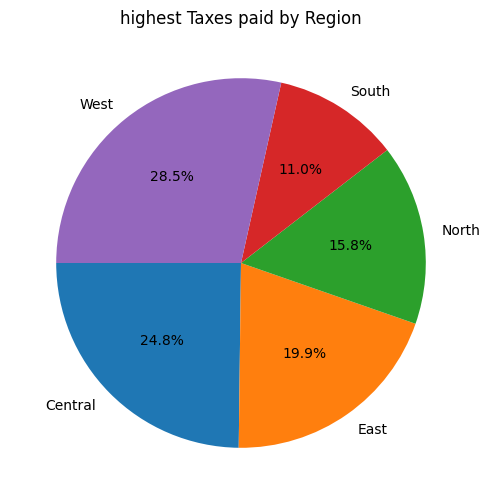

In [ ]:
highest_tax_by_Region=df.groupby("Region")["Taxes"].sum().reset_index()
plt.figure(figsize=(6,6))
plt.pie(highest_tax_by_Region["Taxes"],labels=highest_tax_by_Region["Region"],autopct="%1.1f%%",startangle=180)
plt.title("highest Taxes paid by Region")
plt.show()